In [45]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [46]:
#%cd drive/My \ Drive/NLP/Project/Text_Summarization

[Errno 2] No such file or directory: 'drive/My  Drive/NLP/Project/Text_Summarization'
/content/drive/My  Drive/NLP/Project/Text_Summarization


In [ ]:
%cd drive/My \ Drive/Text_Summarization

## The below common code is borrowed from the EDA.ipyb.

In [47]:
import json
import pandas as pd
import numpy as np
import re

In [48]:
with open("./Data/telehealth_article_texts.txt") as f:
    #Skip header
    for i in range(4):
        next(f) 
    corpus = f.read()

In [49]:
dict_articles = json.loads(corpus.replace("\n",""))

In [50]:
df_articles = pd.DataFrame.from_dict(dict_articles,orient="index",columns=["Content"]).reset_index().drop(columns=["index"])

In [51]:
df_articles.head()

,Content
0,Veterans face a variety of stressors related t...
1,The impact of the COVID-19 pandemic on the chi...
2,"In November 2019, COVID-19—the infectious, hig..."
3,Anxiety and depressive disorders are among the...
4,"In mid-March, 2020, the authors—as well as the..."


In [52]:
df_metadata = pd.read_excel("Data/Metadata_telehealth_article_key_2.25.xlsx",index_col="Index")
df_metadata.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation
Index,,,,,,,
0,Psychological Servies,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea..."
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca..."
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo..."
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar..."
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)...."


In [53]:
#Ensure both Indexes are of same type before merge
assert df_metadata.index.dtype == df_articles.index.dtype

#Merge dataframes
df_metadata = df_metadata.merge(df_articles,left_index=True,right_index=True,how="left")

In [54]:
df_metadata.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content
Index,,,,,,,,
0,Psychological Servies,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea...",Veterans face a variety of stressors related t...
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca...",The impact of the COVID-19 pandemic on the chi...
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo...","In November 2019, COVID-19—the infectious, hig..."
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar...",Anxiety and depressive disorders are among the...
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)....","In mid-March, 2020, the authors—as well as the..."


In [55]:
def clean_text(text,lowercase=False):
    
    corpus =  text

    punc = string.punctuation.replace("-","")
    
    if lowercase:
        corpus = text.lower()

    translator = str.maketrans(" "," ",punc)
    
    clean_corpus = corpus.translate(translator)
    
    remove_extra_whitespaces = [token.strip() for token in clean_corpus.split()]

    return " ".join(remove_extra_whitespaces)





In [56]:
df_metadata["Content_Length"] = df_metadata["Content"].apply(lambda text: len(text))
df_metadata["Abstract_Length"] = df_metadata["Abstract"].apply(lambda text: len(str(text)))
df_metadata["Parsed_Keywords"] = df_metadata["Keywords"].apply(lambda keywords: str(keywords).replace("\n\n"," ").split(" ")[1:])
df_metadata["Parsed_Keywords_Length"] = df_metadata["Parsed_Keywords"].apply(lambda text: len(text))


#Have an idea of reference amount per document
df_metadata["et_al_Count"] = df_metadata["Content"].apply(lambda text: len(list(re.finditer("et al",text))))


In [57]:
import string

In [58]:
df_metadata["Clean_Content"] = df_metadata["Content"].apply(lambda text: clean_text(text,lowercase=False))
df_metadata["Clean_Content_length"] = df_metadata["Clean_Content"].apply(lambda text: len(text))

df_metadata.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content,Content_Length,Abstract_Length,Parsed_Keywords,Parsed_Keywords_Length,et_al_Count,Clean_Content,Clean_Content_length
Index,,,,,,,,,,,,,,,
0,Psychological Servies,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea...",Veterans face a variety of stressors related t...,37477,2411,"[telepsychology,, meta-analysis,, veteran,, vi...",5,50,Veterans face a variety of stressors related t...,36423
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca...",The impact of the COVID-19 pandemic on the chi...,74025,1577,"[remote, child, custody, evaluations,, videoco...",10,48,The impact of the COVID-19 pandemic on the chi...,72009
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo...","In November 2019, COVID-19—the infectious, hig...",63568,1842,"[forensic, e-mental, health,, telehealth,, tel...",8,128,In November 2019 COVID-19—the infectious highl...,61640
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar...",Anxiety and depressive disorders are among the...,30147,1650,"[education, and, training,, telepsychology,, C...",6,21,Anxiety and depressive disorders are among the...,29392
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)....","In mid-March, 2020, the authors—as well as the...",42367,1871,"[remote, psychotherapy,, Covid-19,, pandemic,,...",6,14,In mid-March 2020 the authors—as well as the m...,41383


## **Topic Modeling**

## Latent Semantic Analysis (LSA) or Latent Semantic Indexing (LSI): Use Singular Value Decomposition (SVD) algorithm to extract hidden topics in corpus.

In [125]:
debug=True

In [80]:
from gensim.parsing.preprocessing import preprocess_documents
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LsiModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import pandas as pd

In [81]:
# Retrieve an array of cleaned document text corpus
text_corpus = df_metadata["Clean_Content"].values

**Function for build a dictionary and preprocess a list or array of document texts:**

In [102]:
def build_dictionary_preprocess_corpus(text_corpus):
  
  # Preprocess documents 
  processed_corpus = preprocess_documents(text_corpus)

  # Create a dictionary
  dictionary = Dictionary(processed_corpus)
  
  # Create a list of lists of bow for documents
  bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]

  return dictionary, bow_corpus

**Function for compute coherence score of a LSI model by give number of topics:**

In [104]:
def compute_lsi_coherence_score(corpus, dictionary, k):
  
   lsi_model = LsiModel(corpus=corpus, num_topics=k, id2word = dictionary)
   coherence = CoherenceModel(model=lsi_model,
                              corpus=corpus,
                              dictionary=dictionary,
                              coherence='u_mass')
   return coherence.get_coherence()

**Function for generate coherece scores of LSI model by given minimum and maximum number of topics.  The coherence scores and the best number of topics are returned:**

In [105]:
def generate_lsi_coherence_scores(min_topics, max_topics, bow_corpus):
  
  coherence_scores=[]
  min_score=0
  best_num_topics=1

  for k in range(min_topics, max_topics):
    score=compute_lsi_coherence_score(bow_corpus, dictionary, k)
    coherence_scores.append(score)

    if(score<=min_score):
      min_score=score
      best_num_topics=k

  return coherence_scores, best_num_topics

**Function for plotting coherece scores:**

In [107]:
import matplotlib.pyplot as plt
import matplotlib.style as style
#%matplotlib inline

def plot_coherence_scores(min_topics, max_topics, coherence_scores):
  style.use('fivethirtyeight')

  x = [int(i) for i in range(min_topics, max_topics)]

  plt.figure(figsize=(10,8))
  plt.plot(x, coherence_scores)
  plt.xlabel('Number of topics')
  plt.ylabel('Coherence Value')
  plt.title('Coherence Scores by number of Topics')

**Function for printing topics of a LSI model, it also returns that model:**

In [123]:
def print_topics(dictionary, num_topics, num_words=10, friendly_print=True):
  
  lsi_model = LsiModel(corpus=bow_corpus, num_topics=num_topics, id2word = dictionary)
  
  if friendly_print:
    # Extract terms from results returned by show_topic()
    for topic_number in range(0, num_topics):
      terms = []
      for term, wt in lsi_model.show_topic(topic_number, num_words):
        terms.append(term)
    
      print(topic_number, terms)

  else:
    topics=lsi_model.print_topics(num_topics, num_words)
    for topic in topics:
      print(topic)

  return lsi_model

**Create a dictionary and BOW coprpus:**

In [103]:
dictionary, bow_corpus = build_dictionary_preprocess_corpus(text_corpus)

**Attempt to find the best number of topics by computing and comparing coherence scores of the LSI model:**

In [106]:
min_topics, max_topics = 5, 100
coherence_scores, best_num_topics = generate_lsi_coherence_scores(min_topics, max_topics, bow_corpus)


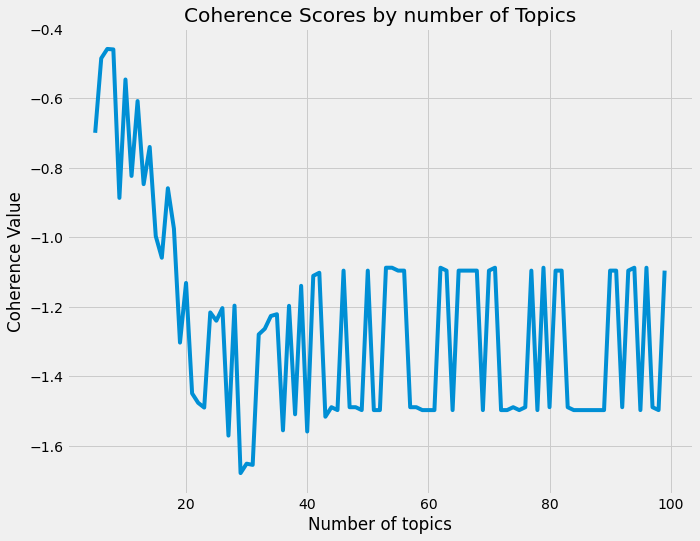

In [108]:
plot_coherence_scores(min_topics, max_topics, coherence_scores)

In [109]:
print('The best number of topics:', best_num_topics)

The best number of topics: 29


**Print the topics:**

In [118]:
print_topics(dictionary, best_num_topics, num_words=20, friendly_print=True)

0 ['health', 'provid', 'telepsycholog', 'servic', 'clinic', 'care', 'mental', 'treatment', 'us', 'practic', 'technolog', 'train', 'client', 'person', 'psychologist', 'studi', 'includ', 'need', 'patient', 'inform']
1 ['telepsycholog', 'health', 'mental', 'clinic', 'care', 'train', 'psychologist', 'practic', 'client', 'traine', 'telement', 'veteran', 'supervisor', 'forens', 'treatment', 'tmh', 'intervent', 'pandem', 'patient', 'particip']
2 ['tmh', 'provid', 'health', 'evalu', 'mental', 'patient', 'veteran', 'forens', 'care', 'hub', 'clinic', 'practic', 'telepsycholog', 'research', 'attitud', 'test', 'intervent', 'site', 'experi', 'client']
3 ['clinic', 'health', 'studi', 'care', 'train', 'tmh', 'evalu', 'particip', 'traine', 'effect', 'treatment', 'supervisor', 'deliv', 'intervent', 'includ', 'mental', 'servic', 'therapi', 'face', 'provid']
4 ['telepsycholog', 'studi', 'inform', 'effect', 'evalu', 'client', 'deliv', 'provid', 'veteran', 'technolog', 'treatment', 'record', 'data', 'ethic

In [124]:
print_topics(dictionary, best_num_topics, num_words=20, friendly_print=False)

(0, '0.328*"health" + 0.252*"provid" + 0.207*"telepsycholog" + 0.191*"servic" + 0.189*"clinic" + 0.188*"care" + 0.167*"mental" + 0.150*"treatment" + 0.146*"us" + 0.135*"practic" + 0.126*"technolog" + 0.123*"train" + 0.122*"client" + 0.114*"person" + 0.114*"psychologist" + 0.113*"studi" + 0.102*"includ" + 0.101*"need" + 0.098*"patient" + 0.096*"inform"')
(1, '0.493*"telepsycholog" + -0.444*"health" + -0.252*"mental" + 0.238*"clinic" + -0.228*"care" + 0.196*"train" + 0.184*"psychologist" + 0.177*"practic" + 0.174*"client" + 0.141*"traine" + -0.121*"telement" + -0.111*"veteran" + 0.099*"supervisor" + -0.092*"forens" + -0.082*"treatment" + -0.077*"tmh" + -0.076*"intervent" + 0.076*"pandem" + -0.070*"patient" + 0.069*"particip"')
(2, '-0.555*"tmh" + -0.373*"provid" + 0.199*"health" + 0.198*"evalu" + 0.194*"mental" + -0.184*"patient" + -0.180*"veteran" + 0.169*"forens" + -0.160*"care" + -0.155*"hub" + -0.115*"clinic" + 0.100*"practic" + 0.098*"telepsycholog" + 0.093*"research" + -0.087*"atti

In [132]:
if(debug):
  print(list(dictionary.items()))
  print(bow_corpus)
  print(len(bow_corpus))

[(0, 'abl'), (1, 'aburizik'), (2, 'abus'), (3, 'accept'), (4, 'access'), (5, 'account'), (6, 'acierno'), (7, 'activ'), (8, 'ad'), (9, 'add'), (10, 'addit'), (11, 'address'), (12, 'addressingsecond'), (13, 'adequ'), (14, 'administ'), (15, 'administr'), (16, 'adult'), (17, 'aert'), (18, 'afghanistan'), (19, 'aggress'), (20, 'allow'), (21, 'al’'), (22, 'america'), (23, 'american'), (24, 'analys'), (25, 'analysi'), (26, 'analysisfor'), (27, 'analysisrecal'), (28, 'analyt'), (29, 'analyz'), (30, 'andor'), (31, 'anger'), (32, 'answer'), (33, 'anxieti'), (34, 'app'), (35, 'appli'), (36, 'appoint'), (37, 'approach'), (38, 'appropri'), (39, 'area'), (40, 'articl'), (41, 'assess'), (42, 'assessmentpubl'), (43, 'assign'), (44, 'associ'), (45, 'author'), (46, 'avail'), (47, 'averag'), (48, 'avoid'), (49, 'awar'), (50, 'barak'), (51, 'barrier'), (52, 'base'), (53, 'bdi'), (54, 'beck'), (55, 'behavior'), (56, 'believ'), (57, 'benefit'), (58, 'better'), (59, 'bia'), (60, 'biasedther'), (61, 'bipolar'